In [106]:
# Run this if you use Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [107]:
! pip install sastrawi

In [108]:
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
 
import gensim
from gensim.models import Word2Vec
import warnings

warnings.filterwarnings(action = 'ignore')

import pandas as pd
import Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import string

import numpy as np

import os, json

# For deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [109]:
# ps = pd.read_csv('dev.csv')
# dtext_a = list(ps['text_a'])

resource_dir = "./data_worthcheck"

df_train = pd.read_csv(f'{resource_dir}/train.csv')
train_text_a = list(df_train['text_a'])
train_label = list(df_train['label'])

df_test = pd.read_csv(f'{resource_dir}/test.csv')

# print("HELLO")
# print(ps)
# print(dtext_a[1:5])
# print(ttext_a[1:5])

text_a = []
label = []
count = 0
for t,l in zip(train_text_a, train_label):
    # if t in dtext_a:
    #     count += 1
    # else:
        text_a.append(t)
        label.append(l)

In [110]:
import nltk
nltk.download(["punkt","stopwords"])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Pre-Processing

In [111]:
# Create stemmer from Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [112]:
# For testing
print(stemmer.stem(text_a[0]))

betewe buka twitter cuman ngetweet liat home berita corona panik pikir ndamau buka2 home yg aware aja i ll stay at home nda rumah kalo nda penting2 banget


In [113]:
# Stemming word with Sastrawi
# NOTE: Because of long stemming process, we won't run this code and instead use pre-stemmed data

'''
# Stemming train data

data = []

for sentence in df_train['text_a']:
    temp = []
    sentence = sentence.lower()
    stemmed_sent = stemmer.stem(sentence)
    temp = str(stemmed_sent).split(" ")
 
    data.append(temp)

# Saving stemmed train data to JSON file for later use, because of long stemming process
file = open(f'{resource_dir}/train_data.json', 'w')
jsonString = json.dumps(data)
file.write(jsonString)
file.close()

# Stemming test data
test_data = []

for sentence in df_test['text_a'].values:
    temp = []
    sentence = sentence.lower()
    stemmed_sent = stemmer.stem(sentence)
    temp = str(stemmed_sent).split(" ")
 
    test_data.append(temp)
  
# Saving stemmed test data to JSON file for later use, because of long stemming process
file = open(f'{resource_dir}/test_data.json', 'w')
jsonString = json.dumps(test_data)
file.write(jsonString)
file.close()
'''

# TOO LONG, use previously preprocessed sentences



'\n# Stemming train data\n\ndata = []\n\nfor sentence in df_train[\'text_a\']:\n    temp = []\n    sentence = sentence.lower()\n    stemmed_sent = stemmer.stem(sentence)\n    temp = str(stemmed_sent).split(" ")\n \n    data.append(temp)\n\n# Saving stemmed train data to JSON file for later use, because of long stemming process\nfile = open(f\'{resource_dir}/train_data.json\', \'w\')\njsonString = json.dumps(data)\nfile.write(jsonString)\nfile.close()\n\n# Stemming test data\ntest_data = []\n\nfor sentence in df_test[\'text_a\'].values:\n    temp = []\n    sentence = sentence.lower()\n    stemmed_sent = stemmer.stem(sentence)\n    temp = str(stemmed_sent).split(" ")\n \n    test_data.append(temp)\n  \n# Saving stemmed test data to JSON file for later use, because of long stemming process\nfile = open(f\'{resource_dir}/test_data.json\', \'w\')\njsonString = json.dumps(test_data)\nfile.write(jsonString)\nfile.close()\n'

In [114]:
# Open previously pre-stemmed data

file = open(f"{resource_dir}/prestemmed_train_data.json", 'r')
data = json.load(file)
file.close()

file = open(f"{resource_dir}/prestemmed_test_data.json", 'r')
test_data = json.load(file)
file.close()

In [115]:
# Create, build, and train CBOW model with WOrd2Vec
w2v_model = gensim.models.Word2Vec( min_count=5,
                                window=2,
                                vector_size=100,
                                sample=6e-5, 
                                alpha=0.03, 
                                min_alpha=0.0007, 
                                negative=20)

w2v_model.build_vocab(data)
w2v_model.train(data, total_examples = w2v_model.corpus_count, epochs=30)

(4387691, 10114530)

In [116]:
# Encode the Label
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_train['label'] = label_encoder.fit_transform(df_train['label'])
df_test['label'] = label_encoder.transform(df_test['label'])

In [117]:
# Tokenize text
max_length = 127

tokenizer = Tokenizer(num_words=12000, oov_token="<oov>")
tokenizer.fit_on_texts(data)

# this takes our sentences and replaces each word with an integer
X_train = tokenizer.texts_to_sequences(data)

# print(X_train)

# we then pad the sequences so they're all the same length
X_train = pad_sequences(X_train, maxlen=max_length)

y_train = df_train['label'].copy()

In [118]:
X_test = tokenizer.texts_to_sequences(test_data)
X_test = pad_sequences(X_test, maxlen=max_length)

y_test = df_test['label'].copy()

In [119]:
# Create embedding matrix
max_features = 200000
embedding_dim = 100

word_index = tokenizer.word_index
num_words = min(len(word_index) + 1, max_features)

# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# for each word in tokenizer, lets try to find that work in our w2v model
rand_counter = 0
for word, i in word_index.items():
  if i >= max_features:
    continue

  try:
    # Word available on the Word2Vec model
    embedding_vector = w2v_model[word]
    # rand_counter -= 1
    embedding_matrix[i] = embedding_vector
  except:
    # Not available on the Word2Vec model, assign random vector
    rand_counter += 1
    embedding_matrix[i] = np.random.randn(100)

# rand_counter

# Percobaan dengan Model 1

Urutan Layer:
- Embedding
- Bidirectional LSTM dengan jumlah unit 32
- Dropout dengan rate 0.2
- Dense dengan activation "sigmoid"

In [120]:
# Create classification model
model = tf.keras.Sequential()

# Embedding layer using the embedding matrix from Word2Vec
model.add( tf.keras.layers.Embedding (
    num_words,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 100)         4025900   
                                                                 
 bidirectional_10 (Bidirecti  (None, 64)               34048     
 onal)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,060,013
Trainable params: 34,113
Non-trainable params: 4,025,900
_________________________________________________________________


In [121]:
history = model.fit(X_train, y_train, epochs=5, batch_size=128, verbose=1, validation_split=0.1)

Epoch 1/5
152/152 [==============================] - 60s 370ms/step - loss: 0.5166 - accuracy: 0.7437 - val_loss: 0.4203 - val_accuracy: 0.8251
Epoch 2/5
152/152 [==============================] - 56s 366ms/step - loss: 0.4170 - accuracy: 0.8172 - val_loss: 0.3714 - val_accuracy: 0.8524
Epoch 3/5
152/152 [==============================] - 55s 363ms/step - loss: 0.3768 - accuracy: 0.8428 - val_loss: 0.3381 - val_accuracy: 0.8709
Epoch 4/5
152/152 [==============================] - 55s 365ms/step - loss: 0.3369 - accuracy: 0.8617 - val_loss: 0.3052 - val_accuracy: 0.8815
Epoch 5/5
152/152 [==============================] - 57s 377ms/step - loss: 0.3049 - accuracy: 0.8787 - val_loss: 0.2752 - val_accuracy: 0.8977


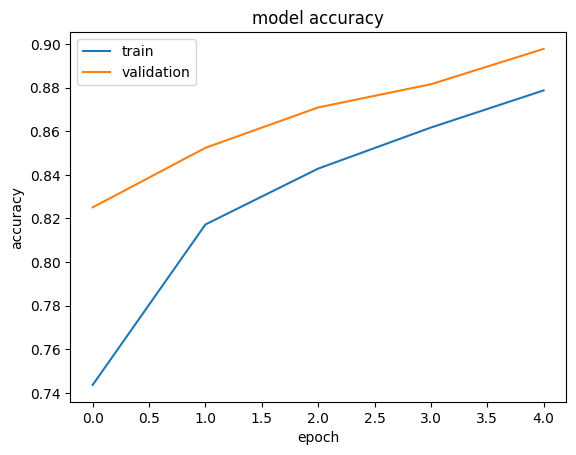

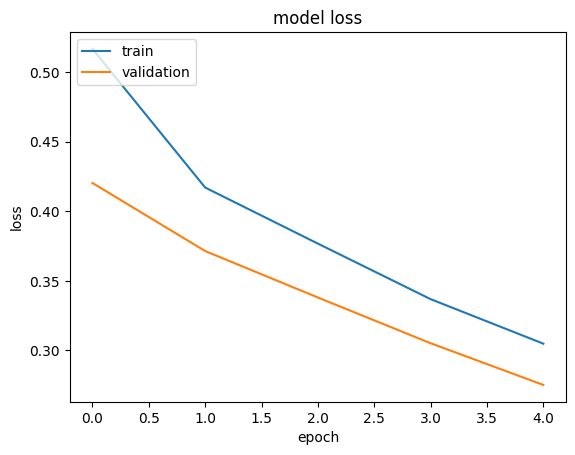

In [122]:
# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

88/88 [==============================] - 5s 51ms/step
Hasil Model 1
Accuracy:  0.8467857142857143
Precision:  0.7396551724137931
Recall:  0.6067892503536068
F1:  0.6666666666666667

Confusion Matrix:


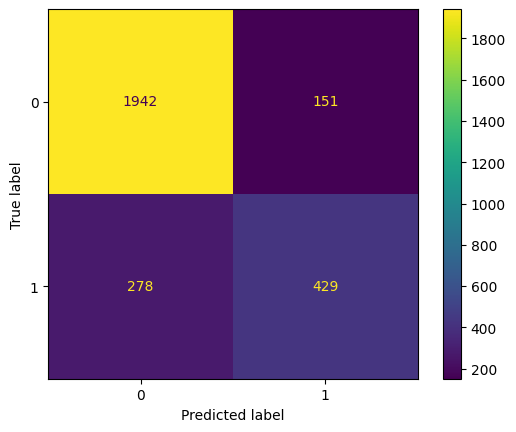

In [123]:
# For evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

y_hat = model.predict(X_test) 
pred = np.round(y_hat)

# Evaluate
print("Hasil Model 1")
print("Accuracy: ", accuracy_score(y_test, pred))
print("Precision: ", precision_score(y_test, pred))
print("Recall: ", recall_score(y_test, pred))
print("F1: ", f1_score(y_test, pred))
print()
print("Confusion Matrix:")
cm = confusion_matrix(y_test, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

# Percobaan dengan Model 2


Urutan Layer:
- Embedding
- LSTM dengan jumlah unit 32
- Dropout dengan rate 0.2
- Dense dengan activation "sigmoid"

In [124]:
# Create classification model
model = tf.keras.Sequential()

# Embedding layer using the embedding matrix from Word2Vec
model.add( tf.keras.layers.Embedding (
    num_words,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False))
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, None, 100)         4025900   
                                                                 
 lstm_14 (LSTM)              (None, 32)                17024     
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,042,957
Trainable params: 17,057
Non-trainable params: 4,025,900
_________________________________________________________________


In [125]:
history = model.fit(X_train, y_train, epochs=5, batch_size=128, verbose=1, validation_split=0.1)

Epoch 1/5
152/152 [==============================] - 29s 176ms/step - loss: 0.5199 - accuracy: 0.7435 - val_loss: 0.4242 - val_accuracy: 0.8181
Epoch 2/5
152/152 [==============================] - 20s 130ms/step - loss: 0.4212 - accuracy: 0.8131 - val_loss: 0.3826 - val_accuracy: 0.8468
Epoch 3/5
152/152 [==============================] - 19s 124ms/step - loss: 0.3753 - accuracy: 0.8431 - val_loss: 0.3429 - val_accuracy: 0.8690
Epoch 4/5
152/152 [==============================] - 19s 122ms/step - loss: 0.3395 - accuracy: 0.8612 - val_loss: 0.3209 - val_accuracy: 0.8774
Epoch 5/5
152/152 [==============================] - 19s 128ms/step - loss: 0.3075 - accuracy: 0.8767 - val_loss: 0.2875 - val_accuracy: 0.8926


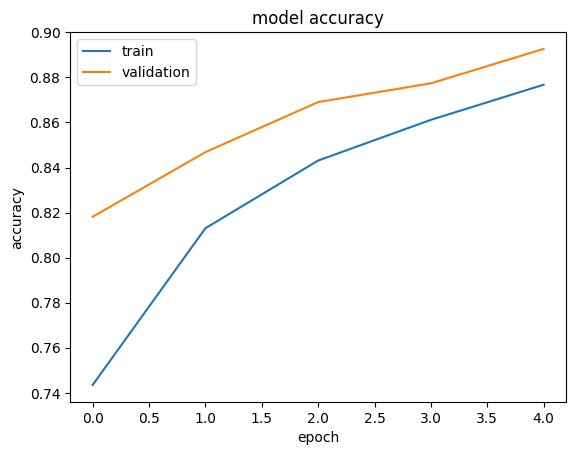

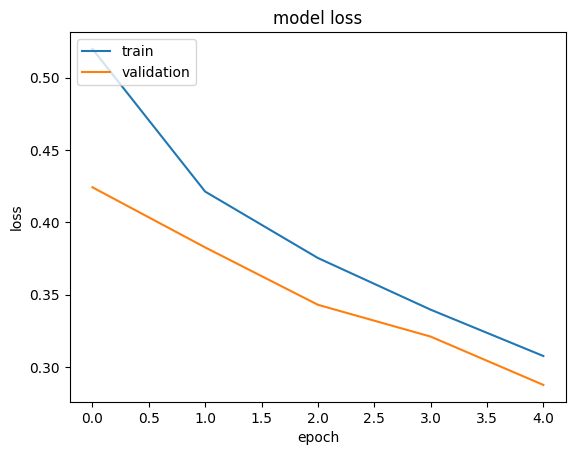

In [126]:
# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [127]:
# X_test = tokenizer.texts_to_sequences(test_data)
# X_test = pad_sequences(X_test, maxlen=max_length, 
#                         padding=pad_type, truncating=trunc_type)

# y_test = df_test['label'].copy()

88/88 [==============================] - 3s 25ms/step
Hasil Model 2
Accuracy:  0.8471428571428572
Precision:  0.7321131447587355
Recall:  0.6223479490806223
F1:  0.6727828746177369

Confusion Matrix:


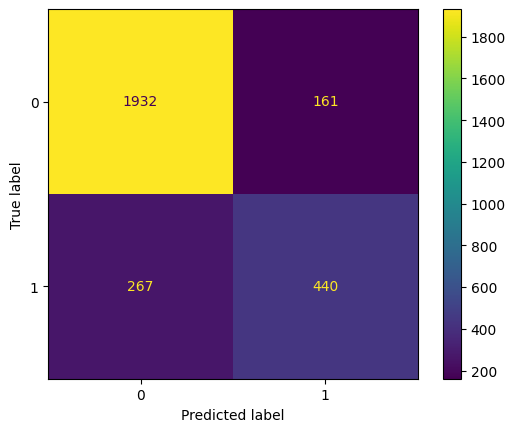

In [128]:
# For evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

y_hat = model.predict(X_test)
pred = np.round(y_hat)

# Evaluate
print("Hasil Model 2")
print("Accuracy: ", accuracy_score(y_test, pred))
print("Precision: ", precision_score(y_test, pred))
print("Recall: ", recall_score(y_test, pred))
print("F1: ", f1_score(y_test, pred))
print()
print("Confusion Matrix:")
cm = confusion_matrix(y_test, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

# Percobaan dengan Model 3

Urutan Layer:
- Embedding
- Bidirectional LSTM dengan jumlah unit 64
- Dropout dengan rate 0.2
- Dense dengan activation "sigmoid"

In [129]:
# Create classification model
model = tf.keras.Sequential()

# Embedding layer using the embedding matrix from Word2Vec
model.add( tf.keras.layers.Embedding (
    num_words,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, None, 100)         4025900   
                                                                 
 bidirectional_11 (Bidirecti  (None, 128)              84480     
 onal)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 4,110,509
Trainable params: 84,609
Non-trainable params: 4,025,900
_________________________________________________________________


In [130]:
history = model.fit(X_train, y_train, epochs=5, batch_size=128, verbose=1, validation_split=0.1)

Epoch 1/5
152/152 [==============================] - 197s 1s/step - loss: 0.4989 - accuracy: 0.7612 - val_loss: 0.4244 - val_accuracy: 0.8223
Epoch 2/5
152/152 [==============================] - 209s 1s/step - loss: 0.4055 - accuracy: 0.8243 - val_loss: 0.3574 - val_accuracy: 0.8561
Epoch 3/5
152/152 [==============================] - 194s 1s/step - loss: 0.3479 - accuracy: 0.8577 - val_loss: 0.3276 - val_accuracy: 0.8672
Epoch 4/5
152/152 [==============================] - 190s 1s/step - loss: 0.3061 - accuracy: 0.8771 - val_loss: 0.2741 - val_accuracy: 0.8963
Epoch 5/5
152/152 [==============================] - 187s 1s/step - loss: 0.2698 - accuracy: 0.8959 - val_loss: 0.2351 - val_accuracy: 0.9112


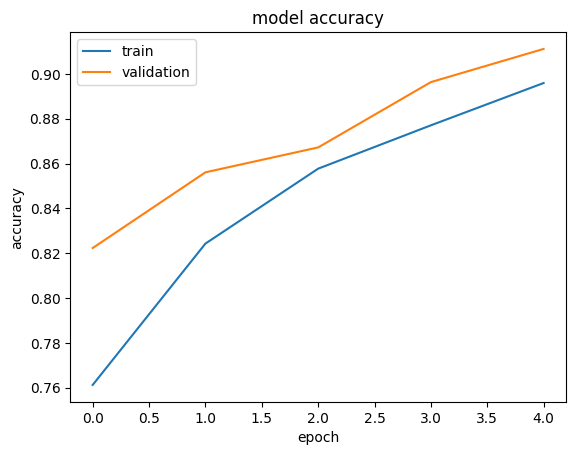

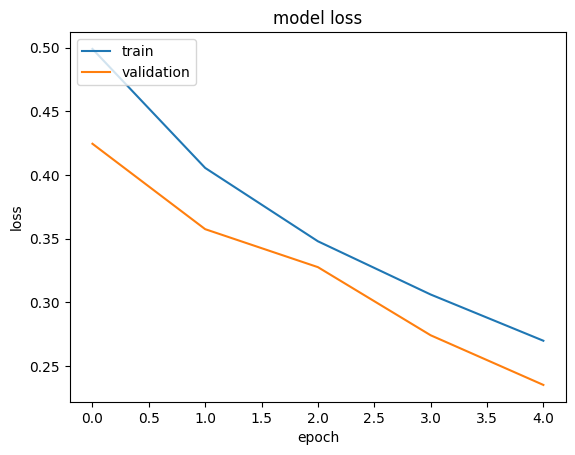

In [131]:
# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [132]:
# X_test = tokenizer.texts_to_sequences(test_data)
# X_test = pad_sequences(X_test, maxlen=max_length, 
#                         padding=pad_type, truncating=trunc_type)

# y_test = df_test['label'].copy()

88/88 [==============================] - 13s 140ms/step
Hasil Model 3
Accuracy:  0.8528571428571429
Precision:  0.7538726333907056
Recall:  0.6195190947666195
F1:  0.6801242236024845

Confusion Matrix:


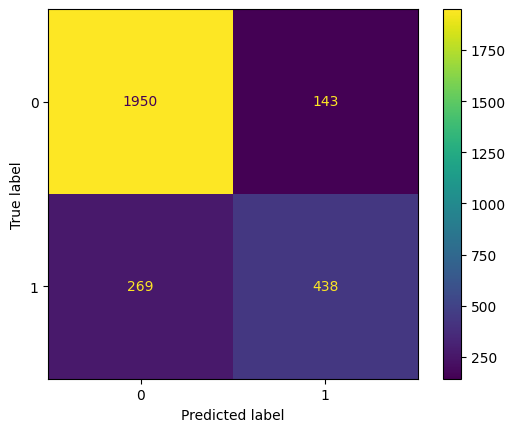

In [133]:
# For evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

y_hat = model.predict(X_test) 
pred = np.round(y_hat)

# Evaluate
print("Hasil Model 3")
print("Accuracy: ", accuracy_score(y_test, pred))
print("Precision: ", precision_score(y_test, pred))
print("Recall: ", recall_score(y_test, pred))
print("F1: ", f1_score(y_test, pred))
print()
print("Confusion Matrix:")
cm = confusion_matrix(y_test, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

# Percobaan dengan Model 4

Urutan Layer:
- Embedding
- Bidirectional LSTM dengan jumlah unit 32
- Dropout dengan rate 0.05
- Dense dengan activation "sigmoid"

In [134]:
# Create classification model
model = tf.keras.Sequential()

# Embedding layer using the embedding matrix from Word2Vec
model.add( tf.keras.layers.Embedding (
    num_words,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
model.add(tf.keras.layers.Dropout(0.05))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, None, 100)         4025900   
                                                                 
 bidirectional_12 (Bidirecti  (None, 64)               34048     
 onal)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,060,013
Trainable params: 34,113
Non-trainable params: 4,025,900
_________________________________________________________________


In [135]:
history = model.fit(X_train, y_train, epochs=5, batch_size=128, verbose=1, validation_split=0.1)

Epoch 1/5
152/152 [==============================] - 34s 193ms/step - loss: 0.5149 - accuracy: 0.7455 - val_loss: 0.4254 - val_accuracy: 0.8269
Epoch 2/5
152/152 [==============================] - 27s 180ms/step - loss: 0.4146 - accuracy: 0.8176 - val_loss: 0.3769 - val_accuracy: 0.8515
Epoch 3/5
152/152 [==============================] - 28s 183ms/step - loss: 0.3665 - accuracy: 0.8441 - val_loss: 0.3426 - val_accuracy: 0.8672
Epoch 4/5
152/152 [==============================] - 27s 178ms/step - loss: 0.3287 - accuracy: 0.8649 - val_loss: 0.3091 - val_accuracy: 0.8815
Epoch 5/5
152/152 [==============================] - 27s 178ms/step - loss: 0.2959 - accuracy: 0.8819 - val_loss: 0.2851 - val_accuracy: 0.8950


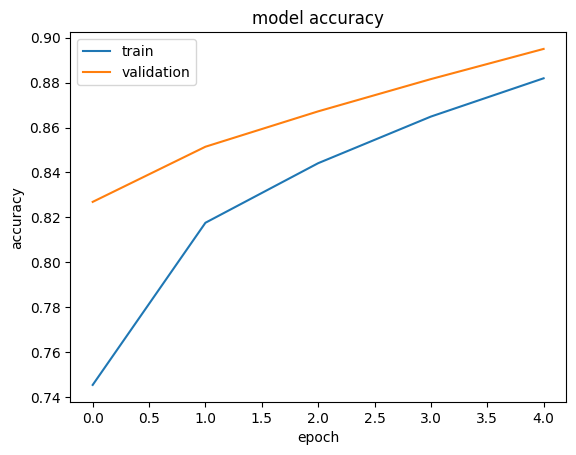

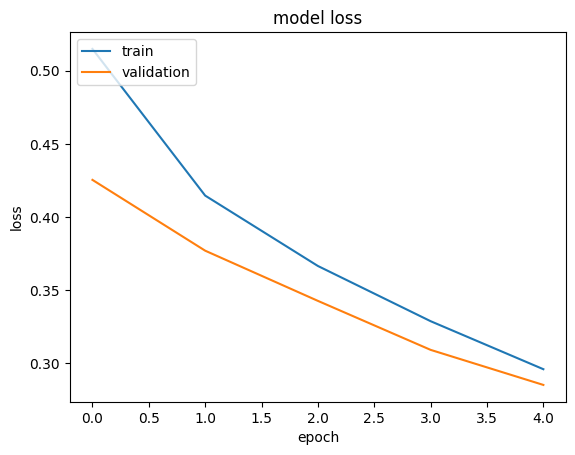

In [136]:
# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [137]:
# X_test = tokenizer.texts_to_sequences(test_data)
# X_test = pad_sequences(X_test, maxlen=max_length, 
#                         padding=pad_type, truncating=trunc_type)

# y_test = df_test['label'].copy()

88/88 [==============================] - 4s 32ms/step
Hasil Model 4
Accuracy:  0.8335714285714285
Precision:  0.6759124087591241
Recall:  0.6548797736916548
F1:  0.6652298850574713

Confusion Matrix:


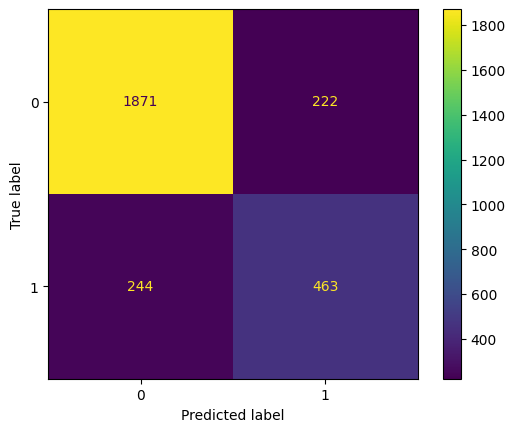

In [138]:
# For evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

y_hat = model.predict(X_test)
pred = np.round(y_hat)

# Evaluate
print("Hasil Model 4")
print("Accuracy: ", accuracy_score(y_test, pred))
print("Precision: ", precision_score(y_test, pred))
print("Recall: ", recall_score(y_test, pred))
print("F1: ", f1_score(y_test, pred))
print()
print("Confusion Matrix:")
cm = confusion_matrix(y_test, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

# Percobaan dengan Model 5

Urutan Layer:
- Embedding
- Bidirectional LSTM dengan jumlah unit 32
- Dropout dengan rate 0.5
- Dense dengan activation "sigmoid"

In [139]:
# Create classification model
model = tf.keras.Sequential()

# Embedding layer using the embedding matrix from Word2Vec
model.add( tf.keras.layers.Embedding (
    num_words,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, None, 100)         4025900   
                                                                 
 bidirectional_13 (Bidirecti  (None, 64)               34048     
 onal)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,060,013
Trainable params: 34,113
Non-trainable params: 4,025,900
_________________________________________________________________


In [140]:
history = model.fit(X_train, y_train, epochs=5, batch_size=128, verbose=1, validation_split=0.1)

Epoch 1/5
152/152 [==============================] - 30s 170ms/step - loss: 0.5176 - accuracy: 0.7501 - val_loss: 0.4410 - val_accuracy: 0.8117
Epoch 2/5
152/152 [==============================] - 26s 174ms/step - loss: 0.4369 - accuracy: 0.8021 - val_loss: 0.3944 - val_accuracy: 0.8376
Epoch 3/5
152/152 [==============================] - 27s 176ms/step - loss: 0.3931 - accuracy: 0.8344 - val_loss: 0.3573 - val_accuracy: 0.8561
Epoch 4/5
152/152 [==============================] - 27s 175ms/step - loss: 0.3627 - accuracy: 0.8506 - val_loss: 0.3274 - val_accuracy: 0.8815
Epoch 5/5
152/152 [==============================] - 28s 183ms/step - loss: 0.3331 - accuracy: 0.8665 - val_loss: 0.3037 - val_accuracy: 0.8876


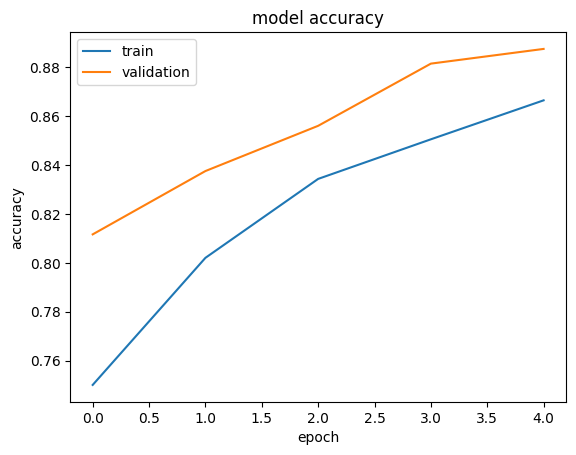

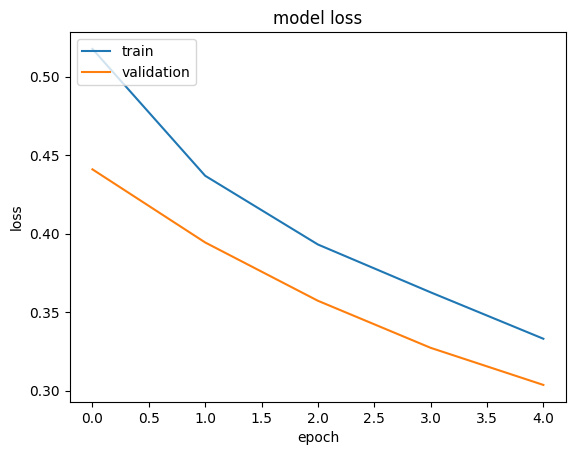

In [141]:
# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [142]:
# X_test = tokenizer.texts_to_sequences(test_data)
# X_test = pad_sequences(X_test, maxlen=max_length, 
#                         padding=pad_type, truncating=trunc_type)

# y_test = df_test['label'].copy()

88/88 [==============================] - 4s 37ms/step
Hasil Model 5
Accuracy:  0.8403571428571428
Precision:  0.7152317880794702
Recall:  0.611032531824611
F1:  0.6590389016018307

Confusion Matrix:


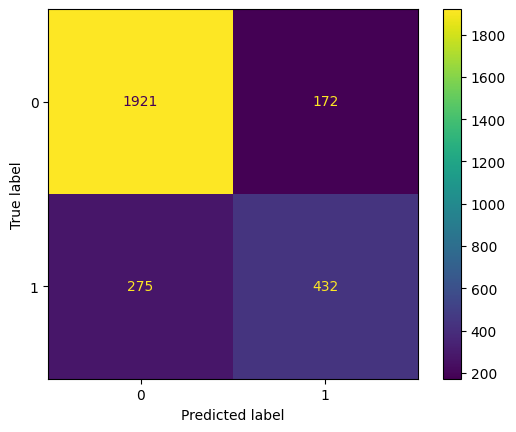

In [143]:
# For evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

y_hat = model.predict(X_test)
pred = np.round(y_hat)

# Evaluate
print("Hasil Model 5")
print("Accuracy: ", accuracy_score(y_test, pred))
print("Precision: ", precision_score(y_test, pred))
print("Recall: ", recall_score(y_test, pred))
print("F1: ", f1_score(y_test, pred))
print()
print("Confusion Matrix:")
cm = confusion_matrix(y_test, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()